In [74]:

from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


In [165]:
#https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE
#pasamos el archivo a .csv
path = 'C:\\Users\\hades\\Downloads\\dataset práctica 1\\data_akbilgic.csv'
df= pd.read_csv(path, encoding='latin', error_bad_lines=False)
X = df.drop("ISE",1)   #Características
y = df["ISE"]          #Target
df.head()

,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [148]:
df.isnull().any().any()


False

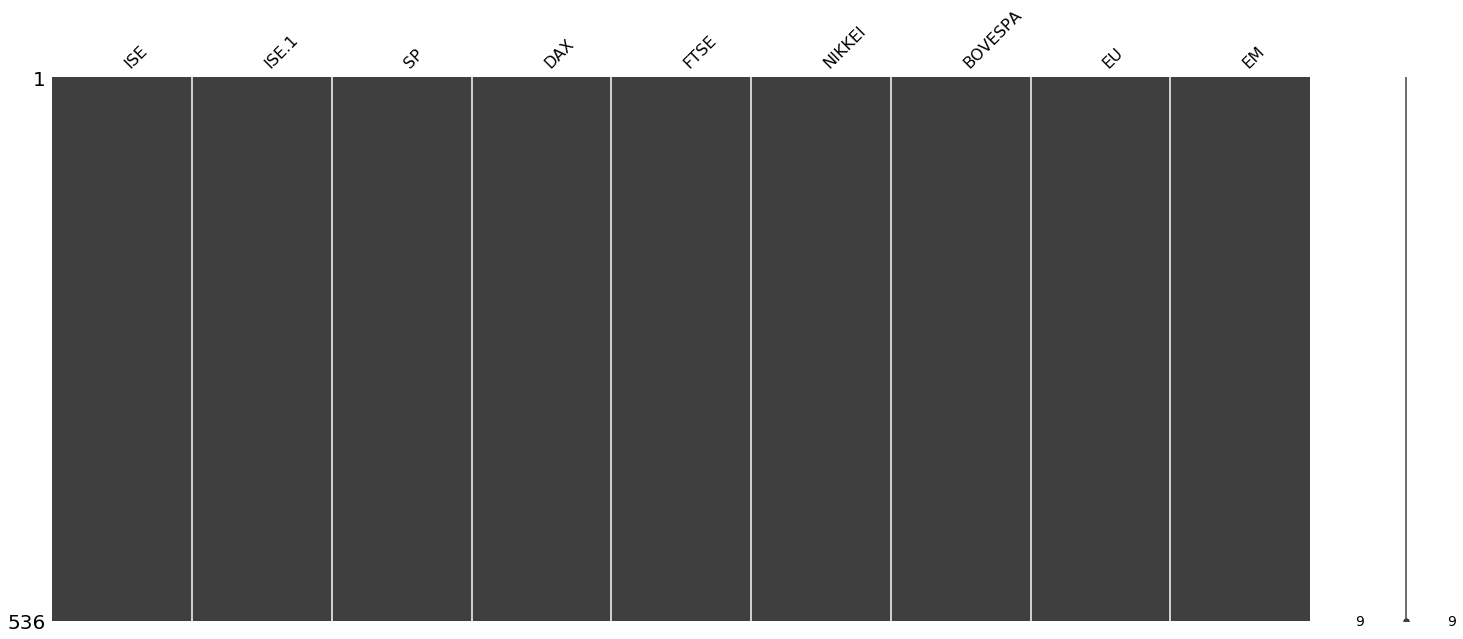

In [149]:
msno.matrix(df)


In [150]:
df.columns[df.isnull().any()].tolist()

[]

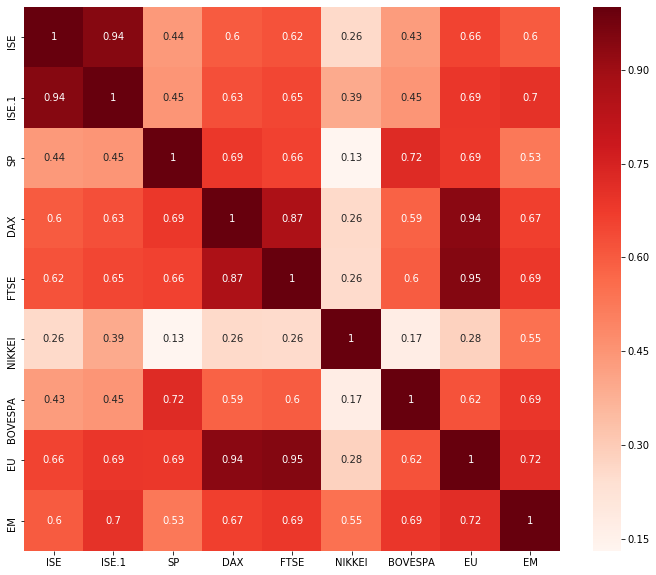

In [151]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [152]:
#Correlación respecto a la variable de salida o target
cor_target = abs(cor["ISE"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.5]
relevant_features

ISE      1.000000
ISE.1    0.942897
DAX      0.602081
FTSE     0.622948
EU       0.655519
EM       0.600295
Name: ISE, dtype: float64

In [157]:
print(df[["ISE.1","DAX"]].corr())
print(df[["ISE.1","FTSE"]].corr())
print(df[["ISE.1","EU"]].corr())
print(df[["ISE.1","EM"]].corr())
print(df[["DAX","EU"]].corr())
print(df[["DAX","EM"]].corr())
print(df[["DAX","FTSE"]].corr())
print(df[["EU","FTSE"]].corr())
print(df[["EU","EM"]].corr())
print(df[["FTSE","EM"]].corr())

          ISE.1       DAX
ISE.1  1.000000  0.629218
DAX    0.629218  1.000000
         ISE.1     FTSE
ISE.1  1.00000  0.64874
FTSE   0.64874  1.00000
          ISE.1        EU
ISE.1  1.000000  0.690761
EU     0.690761  1.000000
          ISE.1        EM
ISE.1  1.000000  0.701954
EM     0.701954  1.000000
          DAX        EU
DAX  1.000000  0.936393
EU   0.936393  1.000000
          DAX        EM
DAX  1.000000  0.665162
EM   0.665162  1.000000
           DAX      FTSE
DAX   1.000000  0.867369
FTSE  0.867369  1.000000
            EU      FTSE
EU    1.000000  0.948963
FTSE  0.948963  1.000000
          EU        EM
EU  1.000000  0.716502
EM  0.716502  1.000000
          FTSE        EM
FTSE  1.000000  0.687543
EM    0.687543  1.000000


In [158]:
#Agregar una columna constante de unos, obligatorio para el modelo sm.OLS
X_1 = sm.add_constant(X)


In [159]:
#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

SP          3.175668e-01
DAX         1.251408e-01
EU          1.247398e-01
FTSE        4.186532e-02
const       1.307709e-02
BOVESPA     7.892385e-04
NIKKEI      8.496941e-07
EM          2.021422e-07
ISE.1      8.803724e-204
dtype: float64

In [160]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['ISE.1', 'FTSE', 'NIKKEI', 'BOVESPA', 'EM']


In [161]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 8 features.
[ True False  True  True  True  True  True  True]
[1 2 1 1 1 1 1 1]


In [162]:
#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 7
Desempeño con 7 características: 0.889661


In [163]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

Número óptimo de características:8
Desempeño mediante la regularización Lasso: 0.908851


C:\Users\hades\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

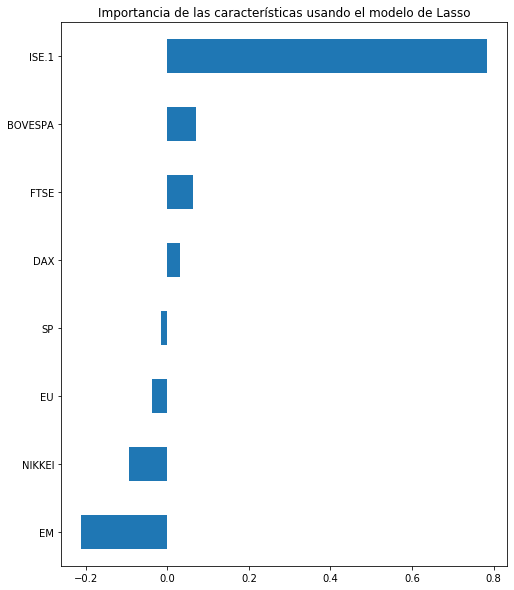

In [164]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")